<a href="https://colab.research.google.com/github/SwordForShinobi/Retail-recommender-system/blob/main/RecSys_Neural_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install livelossplot

import pandas as pd
import numpy as np
import tensorflow as tf
import gc
import random
from sklearn.metrics import accuracy_score
from keras.regularizers import L1, L2
from livelossplot.tf_keras import PlotLossesCallback
from sklearn.preprocessing  import StandardScaler 

# Prepare features from transactions

## Step 1

In [ ]:
trans = pd.read_csv('your_directory') # main/Data/transactions_probe.csv in this repository
max_order_number = trans.groupby('user_id')['order_number'].max().to_frame('max_orders').reset_index()
order_details = trans[['user_id', 'order_id', 'product_id', 'add_to_cart_order', 'reordered']]
each_user_reord_mean = trans.groupby('user_id')['reordered'].mean().to_frame('user_reordered_ratio').reset_index()
item_pos_mean = trans.groupby(['user_id', 'product_id'])['add_to_cart_order'].mean().sort_values().reset_index()
trans_1 = trans.merge(max_order_number, on=['user_id'], how='left')
trans_1['diff'] = trans_1['max_orders'] - trans_1['order_number']
two_plus_four = max_order_number.merge(each_user_reord_mean, on='user_id', how='left')

del each_user_reord_mean
gc.collect()

purchases = trans.groupby('product_id')['order_id'].count().to_frame('product_total_purchases').reset_index()
reo_mean = trans.groupby('product_id')['reordered'].mean().to_frame('reordered_mean').reset_index()
nine_plus_ten = purchases.merge(reo_mean, on='product_id', how='left')

del reo_mean
gc.collect()

0

## Step 2

In [ ]:
nine_plus_ten = nine_plus_ten.fillna(0)
trans_2 = trans_1.groupby(['user_id','product_id'])['order_id'].count().to_frame('order_id_count').reset_index().sort_values(by=['user_id', 'order_id_count'], ascending = [True, False])
first_time = trans_1.groupby(['user_id','product_id'])['order_number'].min().reset_index()
last_time = trans_1.groupby('user_id')['order_number'].max().to_frame('total_orders').reset_index()
all_time = pd.merge(last_time, first_time, on='user_id', how='right')
all_time.columns = ['user_id', 'max_order_number','product_id', 'min_order_number']
all_time['order_number_delta'] = all_time['max_order_number'] - all_time['min_order_number'] + 1
all_time = all_time.sort_values(by=['user_id', 'order_number_delta'], ascending = [True, False])
df_user_product_ratio = pd.merge(trans_2, all_time, on=['user_id', 'product_id'], how='left')
df_user_product_ratio['waaaat_column'] = df_user_product_ratio['order_id_count'] / df_user_product_ratio['order_number_delta']
df_user_product_ratio.sort_values(by=['user_id', 'waaaat_column'], ascending=[True, False])

del all_time
del first_time
del df_user_product_ratio['order_id_count']
del df_user_product_ratio['max_order_number']
del df_user_product_ratio['min_order_number']
del df_user_product_ratio['order_number_delta']
gc.collect()

trans_2 = trans_2.merge(df_user_product_ratio, on=['user_id', 'product_id'], how='left')
trans_2 = trans_2.sort_values(by=['user_id', 'waaaat_column'], ascending=[True, False])

del df_user_product_ratio
gc.collect()

0

## Step 3

In [ ]:
trans_1['back_order_no'] = trans_1.groupby('user_id')['order_number'].transform(max) - trans_1['order_number'] + 1
last_5_orders = trans_1[trans_1['back_order_no'] <= 5]
train = last_5_orders[last_5_orders['diff'] > 1]
test = last_5_orders[last_5_orders['diff'] < 1]
train_grouped = train.groupby(['user_id','product_id'])[['order_id']].count()
train_grouped.columns = ['count']
test_grouped = test.groupby(['user_id','product_id'])[['order_id']].count()
test_grouped.columns = ['count']
last_5_orders_reordered = last_5_orders.groupby(['user_id','product_id'])[['reordered']].max()
train_grouped = train_grouped.merge(last_5_orders_reordered, on=['user_id', 'product_id'], how='left')
train_grouped = train_grouped.fillna(0) 
test_grouped = test_grouped.merge(last_5_orders_reordered, on=['user_id', 'product_id'], how='left')
test_grouped = test_grouped.fillna(0)

del last_5_orders_reordered
gc.collect()

613

## Step 4

In [ ]:
trans_2_train = trans_2.merge(train_grouped, on=['user_id', 'product_id'])
train = pd.merge(trans_2_train, two_plus_four, on='user_id')
train = train.merge(nine_plus_ten, on='product_id')
trans_2_test = trans_2.merge(test_grouped, on=['user_id', 'product_id'])
test = pd.merge(trans_2_test, two_plus_four, on='user_id')
test = test.merge(nine_plus_ten, on='product_id')

## Final preparations

In [ ]:
y_train = train['reordered'].ravel()# train target
x_train = train.drop(['reordered'], axis=1)# train features
y_test = test['reordered'].ravel()# test target
x_test = test.drop(['reordered'], axis=1)# test features

In [ ]:
scale_features_std = StandardScaler()

In [ ]:
# For train:
user_train = x_train[['user_id', 'max_orders', 'user_reordered_ratio']]
scaler = scale_features_std.fit(user_train)
user_train = scale_features_std.transform(user_train)

product_train = x_train[['product_id', 'order_id_count', 'waaaat_column', 'count', 'product_total_purchases', 'reordered_mean']]
# waaaat_column = order_id_count / (last_order_number - first_order_number ratio)
scaler = scale_features_std.fit(product_train)
product_train = scale_features_std.transform(product_train)

#For test:
user_test = x_test[['user_id', 'max_orders', 'user_reordered_ratio']]
scaler = scale_features_std.fit(user_test)
user_test = scale_features_std.transform(user_test)

product_test = x_test[['product_id', 'order_id_count', 'waaaat_column', 'count', 'product_total_purchases', 'reordered_mean']]
scaler = scale_features_std.fit(product_test)
product_test = scale_features_std.transform(product_test)

# Model building and predictions

In [ ]:
def Model(layers_ammount, l2_rate, dense_start_out=64, lr=1e-3):

  user_input = tf.keras.Input(3,)
  product_input = tf.keras.Input(6,)

  user_flatten = tf.keras.layers.Flatten()(user_input)
  product_flatten = tf.keras.layers.Flatten()(product_input)
  concat_layer = tf.keras.layers.concatenate([user_flatten , product_flatten])


  dense = tf.keras.layers.Dense(dense_start_out, activation='relu', kernel_regularizer=L2(l2_rate))(concat_layer)
  for i in range(1, layers_ammount+1):
    dense = tf.keras.layers.Dense(dense_start_out/2//i, activation='relu', kernel_regularizer=L2(l2_rate))(dense)
  output = tf.keras.layers.Dense(1, activation='sigmoid')(dense)

  model = tf.keras.Model(inputs=[user_input, product_input], outputs=output)

  model.compile(loss='mse',
                optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                metrics='mse')
  return model

In [ ]:
model = Model(2, 0.01) # create model with this parameters and load provided weights (from main/Data/checkpoint.h5)

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True) # allows to look on what we got

In [ ]:
plot_losses = PlotLossesCallback()

path = 'desired path'
checkpoint = tf.keras.callbacks.ModelCheckpoint(path, monitor='val_mse', verbose=1, save_best_only=True, mode='min')

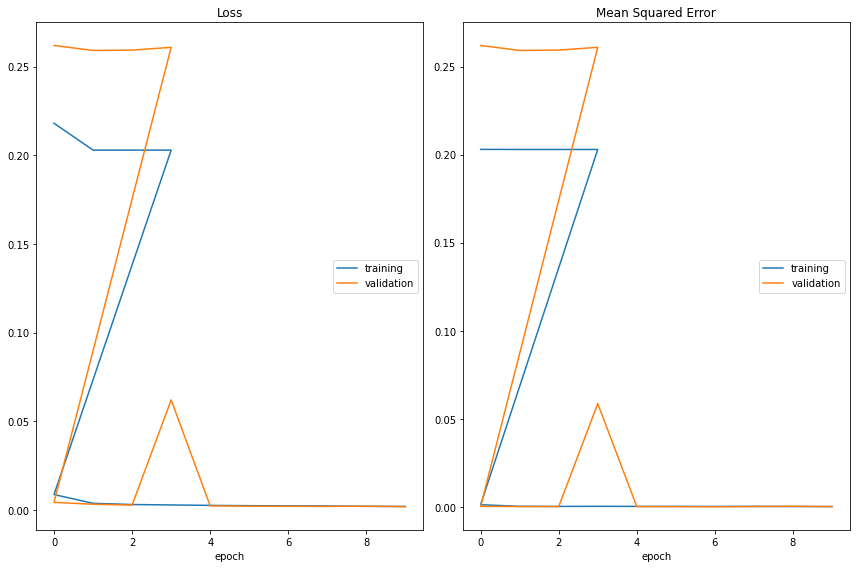

Loss
	training         	 (min:    0.002, max:    0.218, cur:    0.002)
	validation       	 (min:    0.002, max:    0.262, cur:    0.002)
Mean Squared Error
	training         	 (min:    0.000, max:    0.203, cur:    0.000)
	validation       	 (min:    0.000, max:    0.262, cur:    0.000)

Epoch 00010: val_mse did not improve from 0.00009
56702/56702 [==============================] - 251s 4ms/step - loss: 0.0020 - mse: 2.2548e-04 - val_loss: 0.0018 - val_mse: 1.1837e-04


In [ ]:
# You can refit model or just load provided weights in a cell below. Although fitting is not recommended for our probe dataset is rather small
hist = model_3_e2_64.fit([user_train, product_train], #input
                 y_train, # labels
                 batch_size=32, epochs=10, validation_split=0.25,
                 callbacks=[plot_losses, checkpoint])

In [ ]:
model.load_weights('your directory') # weights from this rep: train/Data/checkpoint.h5

In [ ]:
# Evaluate predictions
predicts_original = model.predict([user_test, product_test])

preds_real = []
for i in predicts_original:
  if i > 0.5: # sigmoid threshold to get our ones and zeros
    preds_real.append(1)
  else:
    preds_real.append(0)

accu = accuracy_score(y_test, preds_real)
accu # look at the accuracy

# Getting our top10

In [ ]:
# this is a top10 products for each user, obtained from naive recommender algorithm. It will be in main/Data/top_10_list.npy
# necessarily create this list
top_10 = np.load('your_directory', allow_pickle=True)

In [ ]:
# create dataframe with raw sigmoid column, sorted from high to low
def create_predicted_df(users, products, predictions, columns=['user_id', 'product_id', 'predictions']):
    predicted_df = pd.DataFrame(list(zip(users, products, predictions)), columns=columns)
    def extract_value(array):
      return array[0]
    predicted_df['predictions'] = predicted_df['predictions'].apply(extract_value)
    predicted_df = predicted_df.sort_values(by=['user_id', 'predictions'], ascending=[True, False])
    return predicted_df

In [ ]:
rec_df = create_predicted_df(x_test['user_id'], x_test['product_id'], predicts_original, columns=['user_id', 'product_id', 'predictions'])
rec_df # that's how it looks

,user_id,product_id,predictions
0,1,196,0.975069
1098,1,12427,0.974666
1309,1,10258,0.970747
1408,1,25133,0.967029
1590,1,46149,0.929090
...,...,...,...
692610,206209,31477,0.695112
844490,206209,38730,0.683582
620478,206209,6567,0.670001
885094,206209,22920,0.654735


In [ ]:
# transform it slightly
ditch = rec_df.groupby('user_id')['product_id'].apply(list).reset_index()

In [ ]:
# Add lacking products from each user's top10 which we load above
swap =  random.choices(top_10.tolist()[i], k=10)

for i in ditch.index:
  while len(ditch['product_id'][i]) != 10:
    if len(ditch['product_id'][i]) < 10:
      ditch['product_id'][i].append([x for x in swap if x not in ditch['product_id'][i]]) # exclude repeats in predictions
    elif len(ditch['product_id'][i]) > 10:
      ditch['product_id'][i].remove(ditch['product_id'][i][-1])

In [ ]:
# filter punctuarion from product list (optional)
def filter_punctuation(raw_sample_df):
  characters_to_remove = '[],'
  clear_items_list = []

  for string in raw_sample_df['product_id']:
    for i in characters_to_remove:
      string = str(string).replace(i, '')
    clear_items_list.append(string)
  raw_sample_df['product_id'] = clear_items_list
  return raw_sample_df

In [ ]:
# final predictions for our probe
answer = filter_punctuation(ditch)

In [ ]:
answer # this is how it looks but for full dataset of 100k users

,user_id,product_id
0,1,196 12427 10258 25133 46149 38928 35951 39657 ...
1,2,47209 24852 18523 19156 1559 33754 16589 7781 ...
2,3,39190 47766 21903 17668 43961 38167 24852 2389...
3,7,40852 37602 21137 31683 13198 30391 27690 4727...
4,13,27086 4210 27435 43086 42248 14197 34382 41926...
...,...,...
99995,206202,38837 12919 17038 16797 41177 17459 22220 4585...
99996,206206,29326 21850 45139 38167 24852 23892 6846 24852...
99997,206207,44632 36011 13176 39180 33787 33754 48086 2734...
99998,206208,34213 13176 21137 43086 35939 47626 35688 3428...
